In [3]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
from data_loader import load_main_data, load_movie_titles
from data_transformer import flatten_data
from data_generator import generate_features, generate_biases, generate_user_embeddings, generate_movie_embeddings, generate_movie_embedings_with_genres
from data_splitting import data_split
from update_rules import update_user ,update_movie
from features_update import update_features, update_movie_with_features

import time


all_ratings = "ratings.csv"
all_genres = "movies.csv"

In [4]:
# Loading the main data
start = time.time()
data_user, data_movie, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx = load_main_data(all_ratings)
print("Finished loading main data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Splitting the data into training and testing sets
start = time.time()
data_by_user_train, data_by_user_test, data_by_movie_train = data_split(data_user, data_movie, ratio=0.8)
print("Finished splitting data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Loading movie titles and genres
start = time.time()
genres_of_a_single_movie, list_movies_per_genre, genres_to_idx = load_movie_titles(all_genres, movie_to_idx)  
print("Finished loading movie titles in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the genre data
start = time.time()
movie_genres_flat, index_movies = flatten_data(genres_of_a_single_movie)
print("Finished flattening genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the list of movies per genre
start = time.time()
list_movies_per_genre_flat, index_genres = flatten_data(list_movies_per_genre.values())
print("Finished flattening movies per genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Free up some memory
del genres_of_a_single_movie
del list_movies_per_genre
gc.collect()

Finished loading main data in 714.09 seconds.

Finished splitting data in 3.67 seconds.

Finished loading movie titles in 0.28 seconds.

Finished flattening genre data in 0.03 seconds.

Finished flattening movies per genre data in 0.01 seconds.



0

In [5]:
def convert_to_typed_list(data_list_of_lists):
    """
    Converts a List[List[Tuple(id, rating)]] into a 
    Numba Typed List[NumpyArray].
    """
    typed_list = List()
    for item in data_list_of_lists:
        # Convert tuples to a 2D numpy array of float64
        # Shape will be (N_ratings, 2) where col 0 is ID, col 1 is Rating
        if len(item) > 0:
            typed_list.append(np.array(item, dtype=np.float64))
        else:
            # Handle empty users/movies by adding an empty array
            typed_list.append(np.zeros((0, 2), dtype=np.float64))
    return typed_list

print("Converting data to Numba-friendly structures...")
start = time.time()
# Convert all 4 data structures
data_by_user_train_typed = convert_to_typed_list(data_by_user_train)
data_by_user_test_typed = convert_to_typed_list(data_by_user_test)
data_by_movie_train_typed = convert_to_typed_list(data_by_movie_train)
# We don't strictly need typed list for test if not passed to njit, 
# but consistency helps if you optimize evaluation later.

print("Finished conversion in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")

Converting data to Numba-friendly structures...
Finished conversion in 146.23 seconds.



In [6]:
# Free up some memory
del data_by_user_train
del data_by_user_test
del data_by_movie_train
gc.collect()

8355

In [180]:
N_iterations = 5*10**1
p_lambda = 2.0
p_gamma = 5.0
user_tau = movie_tau = 2.0
embedding_dim = 20

In [181]:
# Generating features, biases, embeddings
# We will start without the features first
num_users = len(idx_to_user)
num_movies = len(idx_to_movie)

# Biases
user_biases, movie_biases = generate_biases(num_users, num_movies)
print("Shapes of biases - Users: {}, Movies: {}".format(user_biases.shape, movie_biases.shape))

# User embeddings
user_embeddings = generate_user_embeddings(num_users, embedding_dim)
print("Shape of user embeddings: {}".format(user_embeddings.shape))

# Features
features_embedding = generate_features(20, embedding_dim, beta=0.05)
print("Shape of features embeddings : {}".format(features_embedding.shape))
features_embedding = np.array(features_embedding)
# Movie embeddings without genres
# movie_embeddings = generate_movie_embeddings(num_movies, embedding_dim)


movie_embeddings = generate_movie_embedings_with_genres(embedding_dim, movie_genres_flat, index_movies, features_embedding, movie_tau=user_tau)
print("Shape of movie embeddings with genres: {}".format(movie_embeddings.shape))

Shapes of biases - Users: (200948,), Movies: (84432,)
Shape of user embeddings: (200948, 20)
Shape of features embeddings : (20, 20)
Shape of movie embeddings with genres: (84432, 20)


In [182]:
features_embedding[:2]

array([[ 0.13347285,  0.09981639, -0.13821606, -0.04528074, -0.59585193,
        -0.24789766, -0.21399962,  0.23264922, -0.4419505 ,  0.01795595,
         0.46671735,  0.08450801, -0.05891654, -0.05626927, -0.19996239,
        -0.00571906, -0.17546476, -0.12824845,  0.29165951,  0.16802331],
       [-0.32979302,  0.11928643, -0.02985736,  0.20677779,  0.07725963,
         0.26371726,  0.60636366, -0.20380292, -0.58803072, -0.06117466,
        -0.10677837,  0.18465011, -0.10823585, -0.26995726, -0.0310561 ,
         0.59672155, -0.25608067,  0.02370687, -0.35946284, -0.0959579 ]])

In [10]:
@njit(parallel=True, nogil=True)
def main_loop(
                data_by_user_train=data_by_user_train_typed,
                data_by_user_test=data_by_user_test_typed,
                data_by_movie_train=data_by_movie_train_typed,
                N_iterations=N_iterations,
                embedding_dim=embedding_dim,
                user_embeddings=user_embeddings,
                user_biases=user_biases,
                movie_embeddings=movie_embeddings,
                movie_biases=movie_biases,
                features_embedding_=features_embedding,
                list_movies_per_genre_flat=list_movies_per_genre_flat,
                index_movie=index_movies,
                movie_genres_flat=movie_genres_flat,
                index_genre=index_genres,
                p_lambda=p_lambda,
                p_gamma=p_gamma,
                user_tau=user_tau,
                movie_tau=movie_tau):
    """
    The main loop for training the model.

    And recording the results.
    """

    N = len(data_by_movie_train)
    M = len(data_by_user_train)

    # Trackers
    error_train = []
    error_test = []
    rmse_train_list = []
    rmse_test_list = []
    error_tracker = []
    
    print("Beginning main loop...")

    # Main loop for training the model would go here
    for iteration in range(N_iterations):

        # Then goes the user embeddings and the user biases update
        user_embeddings, user_biases = update_user(M,
                embedding_dim,
                data_by_user_train,
                movie_embeddings,
                user_embeddings,
                user_biases,
                movie_biases,
                p_lambda=p_lambda,
                user_tau=user_tau)

        movie_embeddings, movie_biases = update_movie_with_features(
            N,
            embedding_dim,
            data_by_movie_train,
            movie_embeddings,
            user_embeddings,
            user_biases,
            movie_biases,
            features_embedding_,
            movie_genres_flat,
            index_movie,
            p_lambda,
            p_gamma,
            movie_tau
        )
        
        # First goes the movie embeddings and the movie biases update
        # movie_embeddings, movie_biases = update_movie(N,
        #          embedding_dim,
        #          data_by_movie_train,
        #          movie_embeddings,
        #          user_embeddings,
        #          user_biases,
        #          movie_biases,
        #          p_lambda=p_lambda,
        #          p_gamma=p_gamma,
        #          user_tau=movie_tau)

        # Here goes the features update
        features_embedding_ = update_features(
                features_embedding_,
                movie_embeddings,
                movie_genres_flat,
                index_genre,
                list_movies_per_genre_flat,
                index_movie,
                embedding_dim,
)


        if (iteration + 1) % max(1, (N_iterations // 10)) == 0:
                print("Progressing...")

        if iteration <= 5 or (iteration + 1) % 10 == 0 or (iteration + 1) % 25 == 0:
            err_test = 0.0
            err_train = 0.0
            total_ratings_train = 0
            total_ratings_test = 0

            for user_idx in range(M):
                current_train = data_by_user_train[user_idx]
                num_ratings_train = len(current_train)
                total_ratings_train += num_ratings_train
                if num_ratings_train == 0:
                    continue

                movies_idx = np.empty(num_ratings_train, dtype=np.int64)
                ratings = np.empty(num_ratings_train, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_train):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_train += np.sum((ratings - preds) ** 2)

            for user_idx in range(M):
                current_test = data_by_user_test[user_idx]
                num_ratings_test = len(current_test)
                total_ratings_test += num_ratings_test
                if num_ratings_test == 0:
                    continue

                movies_idx = np.empty(num_ratings_test, dtype=np.int64)
                ratings = np.empty(num_ratings_test, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_test):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_test += np.sum((ratings - preds) ** 2)

            rmse_train_val = 0.0
            rmse_test_val = 0.0
            if total_ratings_train > 0:
                rmse_train_val = np.sqrt(err_train / total_ratings_train)
            if total_ratings_test > 0:
                rmse_test_val = np.sqrt(err_test / total_ratings_test)

            reg_bias = (p_gamma / 2.0) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
            reg_embed = (user_tau / 2.0) * (np.sum(user_embeddings ** 2) + np.sum(movie_embeddings ** 2))

            err_test_reg = (err_test * (p_lambda / 2.0)) + reg_bias + reg_embed
            err_train_reg = (err_train * (p_lambda / 2.0)) + reg_bias + reg_embed

            error_tracker.append(iteration)
            rmse_train_list.append(rmse_train_val)
            rmse_test_list.append(rmse_test_val)
            error_test.append(err_test_reg)
            error_train.append(err_train_reg)

    return error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, user_biases, movie_biases, user_embeddings, movie_embeddings, features_embedding_

In [183]:
start = time.time()
main_loop_results = main_loop(
    data_by_user_train=data_by_user_train_typed,   
    data_by_user_test=data_by_user_test_typed,     
    data_by_movie_train=data_by_movie_train_typed, 
    N_iterations=N_iterations,
    embedding_dim=embedding_dim,
    user_embeddings=user_embeddings,
    features_embedding_=features_embedding,
    user_biases=user_biases,
    movie_embeddings=movie_embeddings,
    movie_biases=movie_biases
)
print("Finished training in {:.2f} seconds.".format(time.time() - start))

(error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, ub, mb, ue, me, ft) = main_loop_results
print("=" * 25, "\n")
# print(error_tracker,'\n', error_test,'\n', error_train,'\n', rmse_test_list,'\n', rmse_train_list)



Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 543.97 seconds.



In [184]:
ft[:2]

array([[-6.34679751e-02,  1.71463769e-01, -1.64637632e-01,
         2.93613138e-02, -1.02125208e-01, -7.80208551e-02,
        -2.13235067e-01,  1.45512444e-01, -3.62767763e-01,
         5.17119049e-04, -1.17255038e-01,  1.12292501e-01,
        -4.01160207e-02, -2.38224697e-02, -1.08685626e-01,
         1.20628163e-01, -2.14542239e-03, -1.18607765e-01,
         2.68939068e-02,  1.93976903e-01],
       [-8.94059594e-02, -7.28540755e-02, -8.21145977e-01,
         2.05987397e-01, -1.04169527e-01,  3.96584332e-01,
         3.35291769e-01, -1.23070873e-01, -4.24505201e-01,
         4.07771131e-01, -1.27067292e-01,  9.20942770e-02,
        -3.79702732e-01,  2.26566010e-01,  2.82107460e-01,
         4.17616464e-01, -1.58768852e-01,  5.93856407e-03,
        -4.50171818e-01,  5.69169102e-01]])

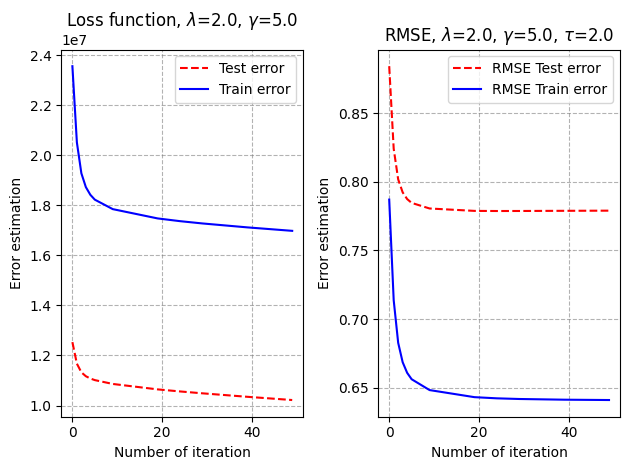

In [185]:
fig, ax = plt.subplots(1,2)
ax[0].plot(error_tracker, error_test, color="red", linestyle="dashed", label="Test error")
ax[0].plot(error_tracker, error_train, color="blue", linestyle="solid", label="Train error")
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Error estimation")
ax[0].set_title(f"Loss function, $\lambda$={p_lambda}, $\gamma$={p_gamma}")
ax[0].legend(loc="upper right")
ax[0].grid(True, linestyle='--', color='gray', alpha=0.6)


ax[1].plot(error_tracker, rmse_test_list, color="red", linestyle="dashed", label="RMSE Test error")
ax[1].plot(error_tracker, rmse_train_list, color="blue", linestyle="solid", label="RMSE Train error")
ax[1].set_xlabel("Number of iteration")
ax[1].set_ylabel("Error estimation")
ax[1].set_title(f"RMSE, $\lambda$={p_lambda}, $\gamma$={p_gamma}, $\\tau$={user_tau}")
ax[1].legend(loc="upper right")
ax[1].grid(True, linestyle='--', color='gray', alpha=0.6)

plt.tight_layout()
# plt.suptitle(f"Error estimation for K={embedding_dim} $\lambda$ = {p_lambda} $\gamma$ = {p_gamma} $\tau$ = {user_tau}$", y=1.02)
plt.savefig(f"Error_{embedding_dim}_local_{p_lambda}_{p_gamma}_{user_tau}_func_no_feat.pdf")
plt.show()

In [187]:
rmse_test_list[:5]

[0.8841782342746471,
 0.8240617502390349,
 0.8017337951144494,
 0.7922917010584819,
 0.7873934293025362]

In [15]:
# np.save("movie_embeddings.npy", me)
# np.save("user_embeddings.npy", ue)
# np.save("features_embedding.npy", ft)

In [16]:
import pandas as pd

movie_name_df = pd.read_csv(all_genres)

In [188]:
new_user = 1 / np.sqrt(embedding_dim) * np.random.randn(embedding_dim)

#Insert the movie index that the new user has rated
noted_movie_idx = movie_to_idx[1]
rating = 5.0
tau = user_tau

In [211]:
def new_user_recommend(new_user, noted_movie_idx, rating,idx_to_movie=idx_to_movie, movie_name_df=movie_name_df, embed_movie=me, movie_biases=mb, p_lambda=p_lambda, p_gamma=p_gamma, tau=user_tau):
    loop = 20
    bias = 0.0
    movie = embed_movie[noted_movie_idx]
    outer = np.outer(movie, movie)
    invert_this = p_lambda * outer + tau * np.identity(movie.shape[0])
    movie_bias = movie_biases[noted_movie_idx]

    for i in range(loop):
        # Update the user's bias first
        bias = p_lambda * (rating - new_user @ movie - movie_bias)
        bias = bias / (p_lambda + p_gamma)

        # Update the trait vector afterward
        new_user = np.linalg.solve(invert_this, p_lambda * (rating - bias - movie_bias) * movie)

    print("Finished creating user profile")
    print("The movie that the user liked : ", 
      movie_name_df.loc[movie_name_df["movieId"] == idx_to_movie[noted_movie_idx], "title"])
    print("==" * 25,"*" * 5, "==" * 25)
    res = embed_movie @ new_user + bias + 0.05 * movie_biases
    print(res.argsort())
    concat = np.hstack([np.array(range(res.shape[0])).reshape(-1,1).astype(np.int32), res.reshape(-1,1)])
    sorted_res = concat[concat[:, 1].argsort()[::-1]]
    ten_best = sorted_res[:10]
    res =  {
        int(index) : float(rating) for index, rating in ten_best
    }

    mv_idx = list(res.keys())
    real_indexes = []
    for mv in mv_idx:
        real_indexes.append(idx_to_movie[mv])

    names = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "title"]
    genres = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "genres"]

    print()
    print("=" * 100)
    print(f"{'Movie name':<40} || {'Movie genre'}")    
    print("=" * 100)
    for name, genre in zip(names, genres):
        print(f"{name:<40} || {genre}")

In [212]:
new_user_recommend(new_user, noted_movie_idx, rating)

Finished creating user profile
The movie that the user liked :  0    Toy Story (1995)
Name: title, dtype: object
================================================== ***** ==================================================
[12816  5120 11933 ... 20238  1287   415]

Movie name                               || Movie genre
Toy Story (1995)                         || Adventure|Animation|Children|Comedy|Fantasy
Lion King, The (1994)                    || Adventure|Animation|Children|Drama|Musical|IMAX
Pinocchio (1940)                         || Animation|Children|Fantasy|Musical
Bug's Life, A (1998)                     || Adventure|Animation|Children|Comedy
Toy Story 2 (1999)                       || Adventure|Animation|Children|Comedy|Fantasy
Monsters, Inc. (2001)                    || Adventure|Animation|Children|Comedy|Fantasy
Finding Nemo (2003)                      || Adventure|Animation|Children|Comedy
Incredibles, The (2004)                  || Action|Adventure|Animation|Children|Comed

In [213]:
res = np.sort(np.sum(np.square(me), axis=1))
res

array([ 0.24590922,  0.29294493,  0.31555294, ..., 27.08594033,
       29.26653073, 30.32783889], shape=(84432,))

In [214]:
sorted_norm_index = np.argsort(np.sum(np.square(me), axis=1))
print(sorted_norm_index[-10:])

[25401 10705    11  5970  5195   153  3477 19327  5120  3405]


In [221]:
idx_to_movie[11]

166

In [222]:
movie_name_df[movie_name_df['movieId'] == 166]

,movieId,title,genres
164,166,"Doom Generation, The (1995)",Comedy|Crime|Drama


### 2D plots of the trait vectors

#### Features selection (only the two first components)

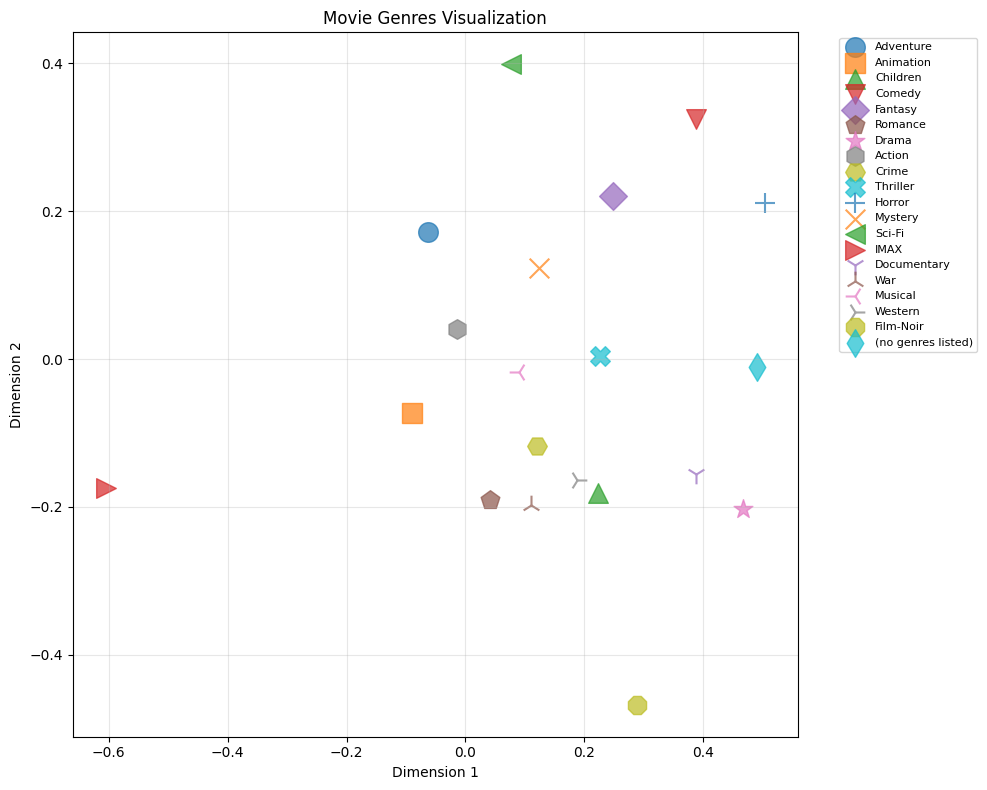

In [193]:
genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(ft[i, 0], ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("movie_genres_visualization_20.pdf")
plt.show()

In [194]:
movie_embedding_mean = np.mean(me, axis=0) 
movie_embedding_std = np.std(me, axis=0)

feature_mean = np.mean(ft, axis=0) 
feature_std = np.std(ft, axis=0) 

std_me = (me - movie_embedding_mean) / movie_embedding_std
std_ft = (ft - feature_mean) / feature_std

#### Principal Component Analysis

[0.12696495 0.09611783]
[463.03141259 402.87517752]


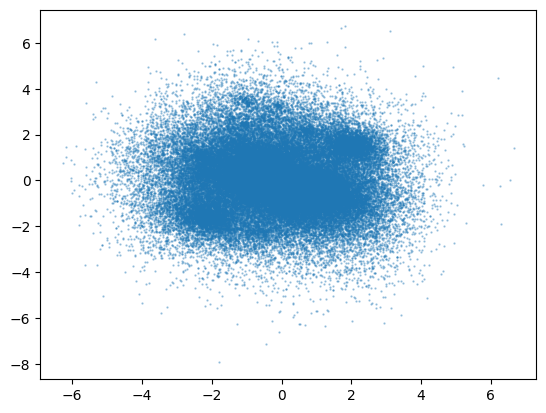

In [195]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_repr = pca.fit_transform(std_me)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(pca_repr[:, 0], pca_repr[:, 1], s=0.4, alpha=0.4)
plt.show()

[0.23243242 0.17496991]
[9.64224907 8.36588106]


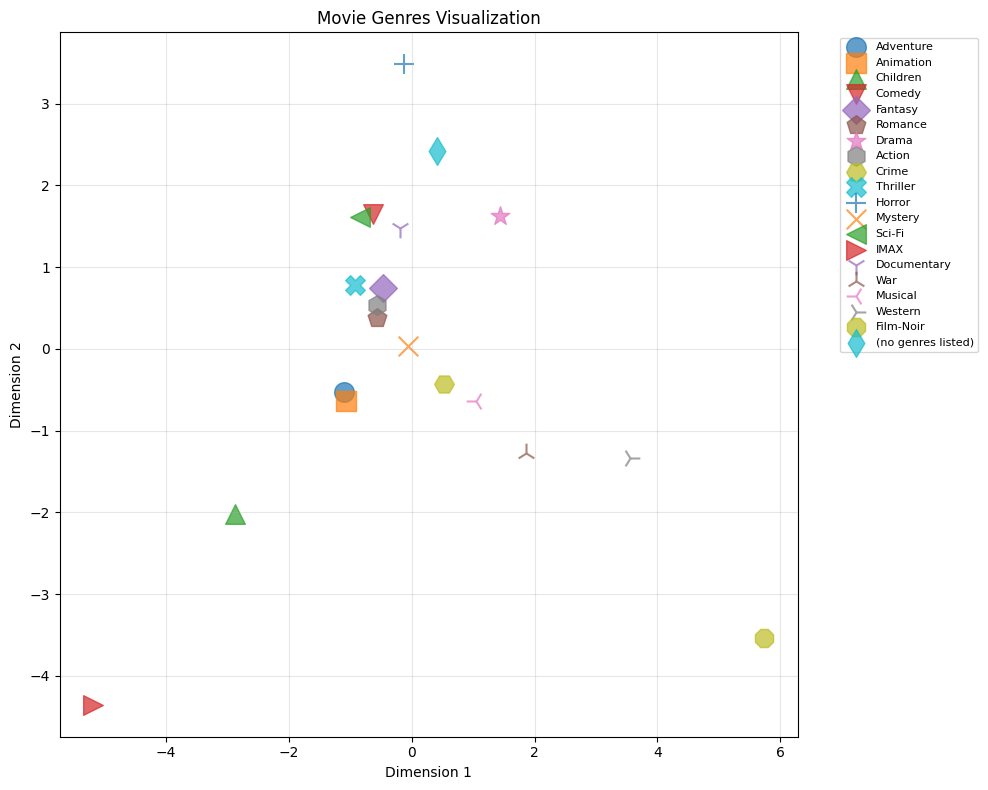

In [196]:
pca_ = PCA(n_components=2)
pca_repr_ft = pca_.fit_transform(std_ft)
print(pca_.explained_variance_ratio_)
print(pca_.singular_values_)


genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(pca_repr_ft[i, 0], pca_repr_ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("movie_genres_visualization.pdf")
plt.show()

#### t-SNE 2D plots

In [197]:
from sklearn.manifold import TSNE
tsne_repr = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(std_me)
tsne_repr.shape

(84432, 2)

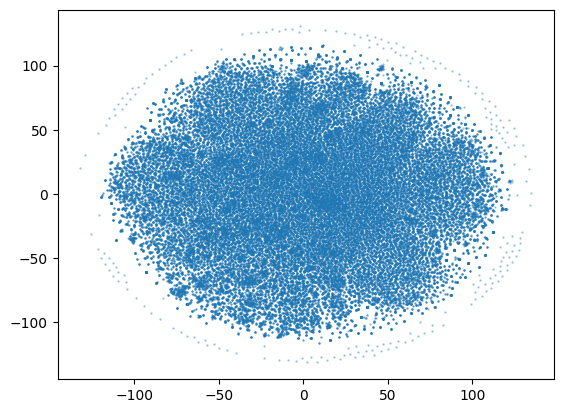

In [198]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], s=0.4, alpha=0.4)
plt.show()

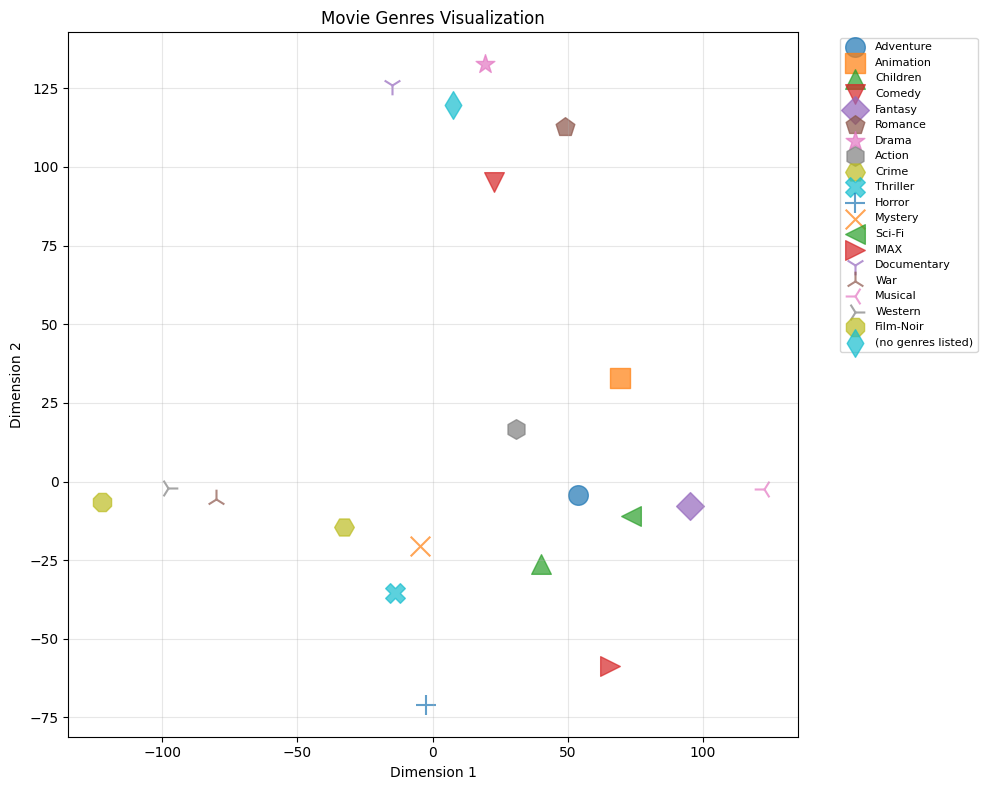

In [199]:
tsne_repr_ft = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(std_ft)
tsne_repr_ft.shape

genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(tsne_repr_ft[i, 0], tsne_repr_ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("movie_genres_visualization.pdf")
plt.show()

In [171]:
print(genres)

samples = []
n_sampling = 20

for genre in genres:
    genre_sample = (
        movie_name_df[
            movie_name_df['genres'].str.contains(genre, case=False, na=False, regex=False)
        ]
        .sample(n=n_sampling, random_state=42)
    )
    samples.append(genre_sample)

samples_df = pd.concat(samples, ignore_index=True)


['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


In [172]:
samples_df.head()

,movieId,title,genres
0,268744,Hotel Transylvania: Transformania (2022),Adventure|Animation|Children|Comedy|Fantasy
1,258349,Lydia Bailey (1952),Adventure
2,109713,Star Wars: Threads of Destiny (2014),Action|Adventure|Sci-Fi
3,137268,Druid Peak (2014),Adventure|Drama
4,149942,Secret Service of the Air (1939),Action|Adventure|Crime


In [173]:
ids = samples_df["movieId"].to_numpy()
ids.shape

(400,)

In [223]:
from collections import defaultdict

genre_to_idx = defaultdict(list)

genre_count = 0
for j, id in enumerate(ids):
    try:
        idx = int(movie_to_idx[id])
        genre_to_idx[genres[genre_count]].append(idx)
    except KeyError:
        continue

    if (j + 1) % n_sampling == 0:
        genre_count += 1


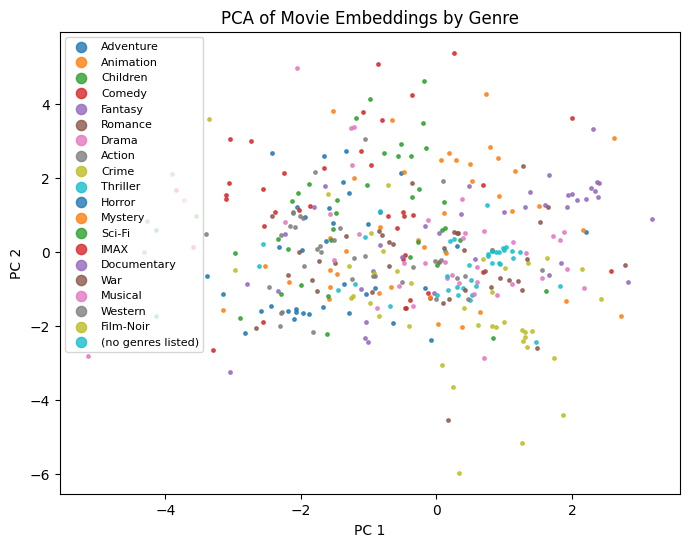

In [224]:
plt.figure(figsize=(8, 6))

for genre, idxs in genre_to_idx.items():
    plt.scatter(
        pca_repr[idxs, 0],
        pca_repr[idxs, 1],
        s=6,
        alpha=0.8,
        label=genre
    )

plt.legend(markerscale=3, fontsize=8)
plt.title("PCA of Movie Embeddings by Genre")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig("dim_12.pdf")
plt.show()


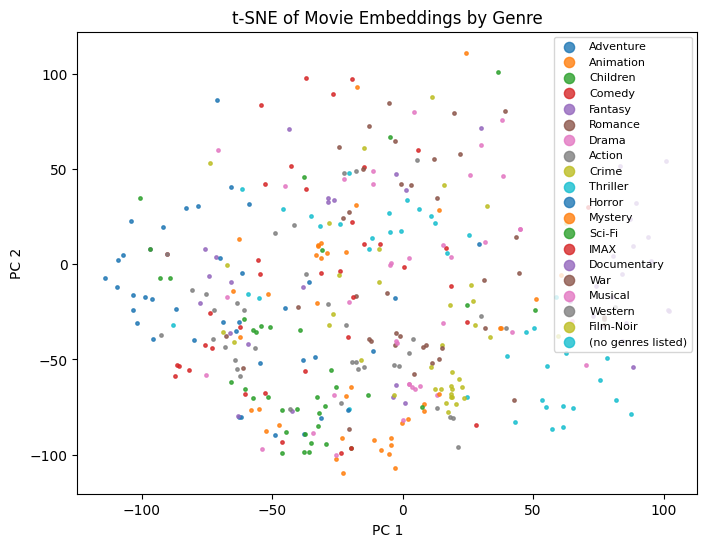

In [225]:
plt.figure(figsize=(8, 6))

for genre, idxs in genre_to_idx.items():
    plt.scatter(
        tsne_repr[idxs, 0],
        tsne_repr[idxs, 1],
        s=6,
        alpha=0.8,
        label=genre
    )

plt.legend(markerscale=3, fontsize=8)
plt.title("t-SNE of Movie Embeddings by Genre")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig("Labels.pdf")
plt.show()